# Final Project Deep Learning- part 1

Lior Weiner 313592099 Yehonatan Bar Moshe 313510844 Ben Botzer 209044676

## Imports

In [10]:
from pathlib import Path
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import torch
import torch.nn.utils.prune as prune
from datasets import load_dataset, load_metric, Dataset, DatasetDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

### Defining The Datasets

In [3]:
df_full=pd.read_csv("phishing_email.csv") # uploading the relevent df

In [4]:
df_full['label'].isnull().sum() #checking to see if there's any data without label


0

In [5]:
df_full.duplicated().sum() # looking for duplicats

408

In [6]:
df_full['text_combined'].duplicated().sum()

408

In [7]:
df_full=df_full.drop_duplicates() #cleaning the data set

In [8]:
#checking how many we have for each label
label_counts = df_full['label'].value_counts()
label_counts

1    42845
0    39233
Name: label, dtype: int64

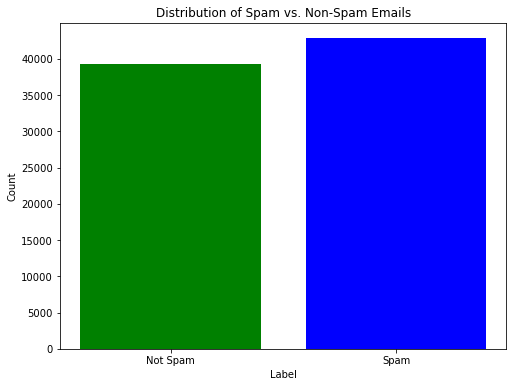

In [9]:
# Creating the bars for visualistion
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Spam vs. Non-Spam Emails')
plt.xticks([0, 1], ['Not Spam', 'Spam'])
plt.show()

In [11]:

spam_emails = df_full[df_full['label'] == 1]
# calculate word frequencies in spam emails without lowercasing and removing punctuation
spam_words = ' '.join(spam_emails['text_combined']).split()
spam_word_freq = Counter(spam_words)

# Get the top 10 most common words in spam emails
top_spam_words = spam_word_freq.most_common(10)

# Convert to DataFrame for better visualization
top_spam_words_df = pd.DataFrame(top_spam_words, columns=['Word', 'Frequency'])


top_spam_words_df

,Word,Frequency
0,_,79487
1,2008,32008
2,10,29417
3,aug,28034
4,email,26270
5,top,23169
6,1,20182
7,company,18227
8,please,18026
9,money,17797


In [12]:
non_spam_emails = df_full[df_full['label'] == 0]

# Calculate word frequencies in non spam emails without lowercasing and removing punctuation
non_spam_words = ' '.join(non_spam_emails['text_combined']).split()
non_spam_word_freq = Counter(non_spam_words)

# Get the top 10 most common words in non spam emails
top_non_spam_words = non_spam_word_freq.most_common(10)

# Convert to DataFrame for better visualization
top_non_spam_words_df = pd.DataFrame(top_non_spam_words, columns=['Word', 'Frequency'])


top_non_spam_words_df

,Word,Frequency
0,_,53543
1,enron,52692
2,1,34257
3,ect,33923
4,2008,33609
5,submissionid,32246
6,would,25111
7,new,24685
8,0,21754
9,please,21722


In [13]:
#checking the most suspicius spam words in the non spam emails
company_count_non_spam = non_spam_word_freq['company']
money_count_non_spam = non_spam_word_freq['money']

print(f"Occurrences of 'company' in non-spam emails: {company_count_non_spam}")
print(f"Occurrences of 'money' in non-spam emails: {money_count_non_spam}")

Occurrences of 'company' in non-spam emails: 11358
Occurrences of 'money' in non-spam emails: 1906


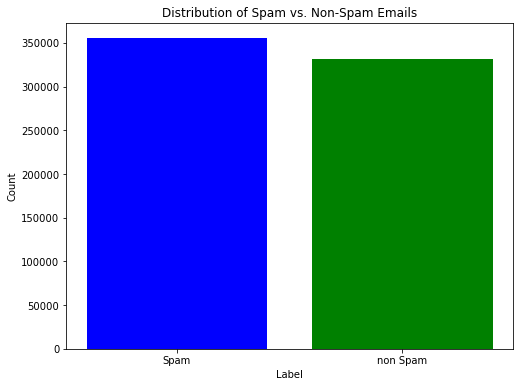

In [14]:
#how many uniuq words are in the types of emails
unique_spam_words = len(set(spam_words))
unique_non_spam_words = len(set(non_spam_words))
# # Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Spam','non Spam'], [unique_spam_words,unique_non_spam_words], color=['blue', 'green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Spam vs. Non-Spam Emails')
plt.show()

In [15]:
#exploring the distibrution of the len of emails
df_full['text_length'] = df_full['text_combined'].apply(len)
text_length_stats = df_full.groupby('label')['text_length'].describe()
print(text_length_stats)


         count         mean           std   min    25%    50%     75%  \
label                                                                   
0      39233.0  1541.456147   3711.537111  11.0  411.0  780.0  1495.0   
1      42845.0  1060.692520  21204.037747   1.0  241.0  391.0  1058.0   

             max  
label             
0       160318.0  
1      4279526.0  


## *Tokenizing*

In [16]:
#  https://huggingface.co/models?sort=downloads
#taking the bert model from hugging face to use the tokanizer for further data exploration
model_name = 'bert-base-uncased'
config = AutoConfig.from_pretrained(model_name)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

C:\ProgramData\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\waine\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [18]:
# the bert tokenaizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [19]:
# defining a function that counts the number of tokans per email
def num_tokens(text):
        tokens = tokenizer.tokenize(text)
        # Get the number of tokens
        num_tokens = len(tokens)
        return num_tokens

In [20]:
df_full["num_tokens"] = df_full['text_combined'].apply(num_tokens) # creating a new column that counts the num of tokens

Token indices sequence length is longer than the specified maximum sequence length for this model (1576 > 512). Running this sequence through the model will result in indexing errors


In [21]:
df_full["num_tokens"].nlargest(10)

80921    2597755
81454     319809
76183     143443
76155     120542
76318      80987
75818      57384
77548      49144
75835      45448
77023      40525
76106      38771
Name: num_tokens, dtype: int64

In [22]:
df_full[["num_tokens", "label"]].nlargest(10, "num_tokens") # checking the emails with the most token and seeing their label.

,num_tokens,label
80921,2597755,1
81454,319809,1
76183,143443,1
76155,120542,1
76318,80987,1
75818,57384,0
77548,49144,1
75835,45448,0
77023,40525,1
76106,38771,1
